# Medical Insurance Premium Price Prediction: Linear Regression Aproach

## Author: Arash Sadeghzadeh

### Data for this notebook can be retrieved from the following address:
 https://www.kaggle.com/datasets/tejashvi14/medical-insurance-premium-prediction



## Table of Contents:
* [Loading Data](#zero-bullet)
* [Data Exploration and Cleaning](#first-bullet)
    - [Data Features](#1-1-bullet)
    - [Delete Outliers](#1-2-bullet)
    - [Select Features](#1-3-bullet)
    - [Select Categorical Features](#1-4-bullet)
    - [Convert Categorical Features](#1-5-bullet)
    - [Determining Normality](#1-6-bullet)
* [Linear Regression](#second-bullet)
    - [A simple Linear Regression](#2-1-bullet)
* [Linear Regression with Regularization](#third-bullet)
    - [Ridge](#3-1-bullet)
    - [Lasso](#3-2-bullet)
    - [Elastic Net](#3-3-bullet)
    - [Linear Regression Results](#3-4-bullet)
    - [Linear Regression: Cross-Validation](#3-5-bullet)
    - [Linear Regression: Different Scalers](#3-6-bullet)
    - [Linear Regression: Hyperparameter Tuning](#3-7-bullet)
* [Final Model](#fourth-bullet)

# Loading Data <a class="anchor" id="zero-bullet"></a>

First, let us load the dataset and have a look at the different features.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy.stats import f_oneway, boxcox
from scipy.stats.mstats import normaltest
from scipy.special import inv_boxcox
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore', module='sklearn')

In [2]:
import seaborn as sns

In [3]:
df = pd.read_csv('./Medicalpremium.csv')

In [4]:
df_raw = df.copy()
df.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000
3,52,1,1,0,1,183,93,0,0,2,28000
4,38,0,0,0,1,166,88,0,0,1,23000


The features in the dataset are as follows:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Age                      986 non-null    int64
 1   Diabetes                 986 non-null    int64
 2   BloodPressureProblems    986 non-null    int64
 3   AnyTransplants           986 non-null    int64
 4   AnyChronicDiseases       986 non-null    int64
 5   Height                   986 non-null    int64
 6   Weight                   986 non-null    int64
 7   KnownAllergies           986 non-null    int64
 8   HistoryOfCancerInFamily  986 non-null    int64
 9   NumberOfMajorSurgeries   986 non-null    int64
 10  PremiumPrice             986 non-null    int64
dtypes: int64(11)
memory usage: 84.9 KB


# Data Exploration and Cleaning <a class="anchor" id="first-bullet"></a>

We need to clean the data to prepare it for the machine learning (ML) methods. Furthermore, we need to explore the data to get familiar with it.

## Data Features <a class="anchor" id="1-1-bullet"></a>

Lets explore the data features and have a look at the distribution of the different features:

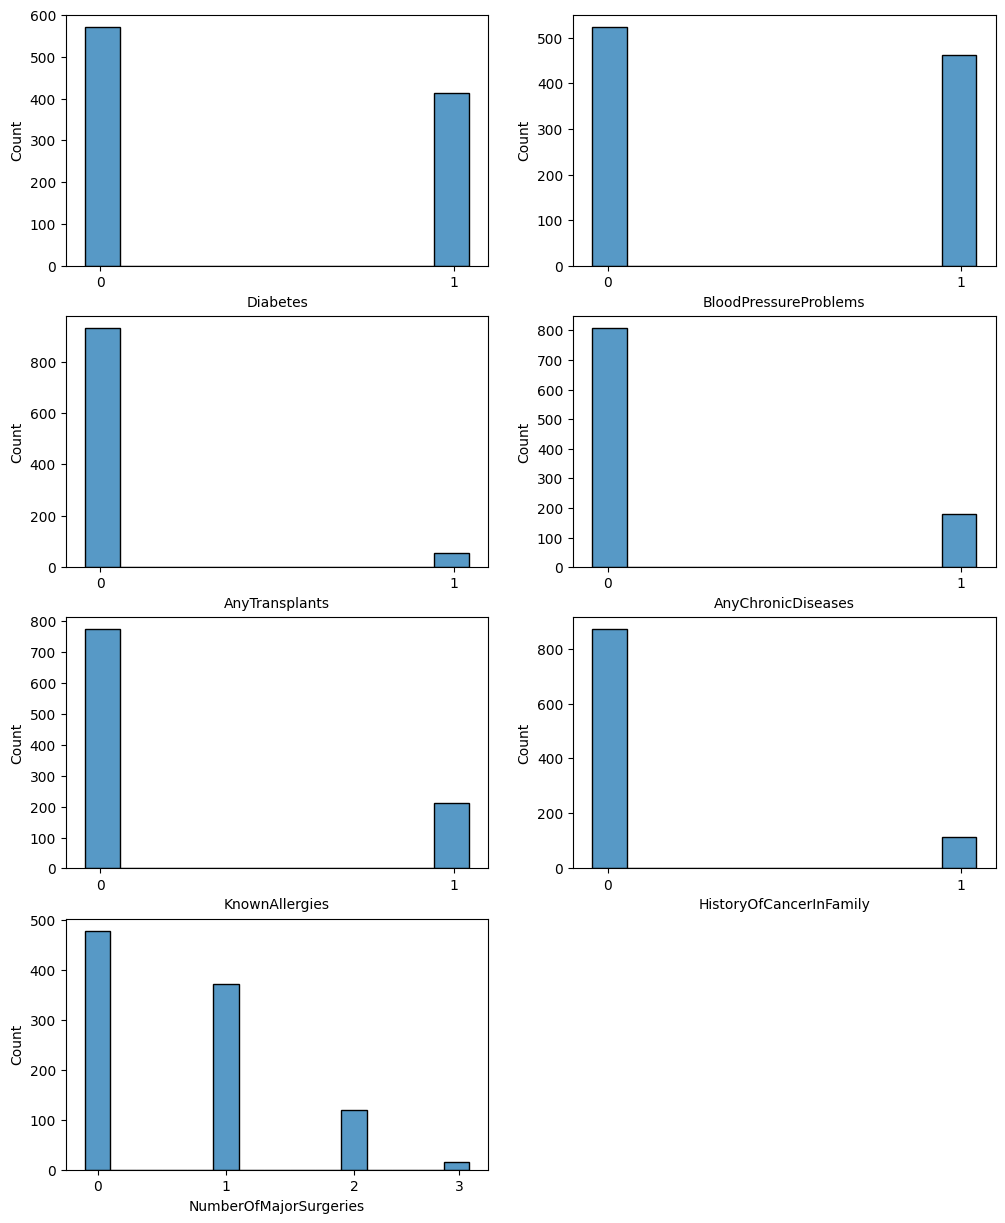

In [6]:
fig, ax  = plt.subplots(4,2, figsize=(12,15))
fig.delaxes(ax[3,1])

cols = ['Diabetes', 'BloodPressureProblems', 'AnyTransplants', 'AnyChronicDiseases', 'KnownAllergies',
      'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries']

for num, col in enumerate(cols):
    ax_def = ax.ravel()[num]
    sns.histplot(df[col], ax=ax_def)
    
    if num==6:
        ax_def.set_xticks([0.1,1.1, 2.1, 2.92])
        ax_def.set_xticklabels([0, 1, 2, 3])
        continue
        
    ax_def.set_xticks([0.04,0.96])
    ax_def.set_xticklabels([0, 1])

In [7]:
df[['Age', 'Height', 'Weight', 'PremiumPrice']].describe()

,Age,Height,Weight,PremiumPrice
count,986.000000,986.000000,986.000000,986.000000
mean,41.745436,168.182556,76.950304,24336.713996
std,13.963371,10.098155,14.265096,6248.184382
min,18.000000,145.000000,51.000000,15000.000000
25%,30.000000,161.000000,67.000000,21000.000000
50%,42.000000,168.000000,75.000000,23000.000000
75%,53.000000,176.000000,87.000000,28000.000000
max,66.000000,188.000000,132.000000,40000.000000


array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Height'}>],
       [<AxesSubplot:title={'center':'Weight'}>,
        <AxesSubplot:title={'center':'PremiumPrice'}>]], dtype=object)

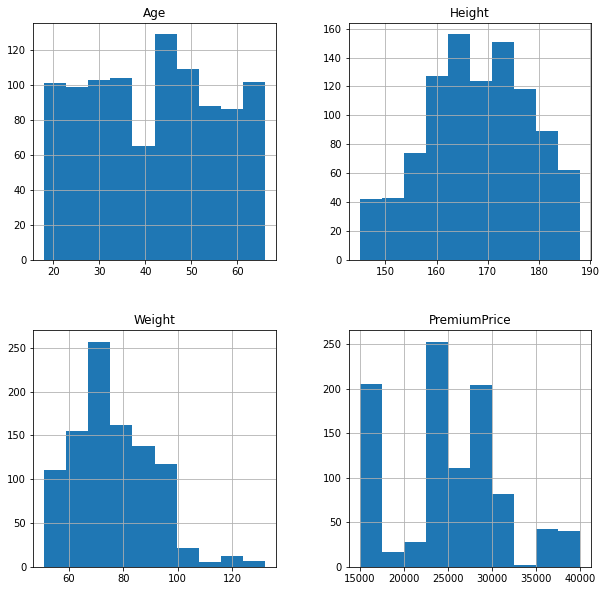

In [7]:
df[['Age', 'Height', 'Weight', 'PremiumPrice']].hist(figsize=(10,10))

## Delete Outliers <a class="anchor" id="1-2-bullet"></a>

In this section, we will investigate the features and take care of outliers to prepare the data for the ML approaches.

In the following, we plot the boxplot for the continuous features to pinpoint the outliers:

[Text(0.5, 0, 'Price'), Text(0, 0.5, 'value')]

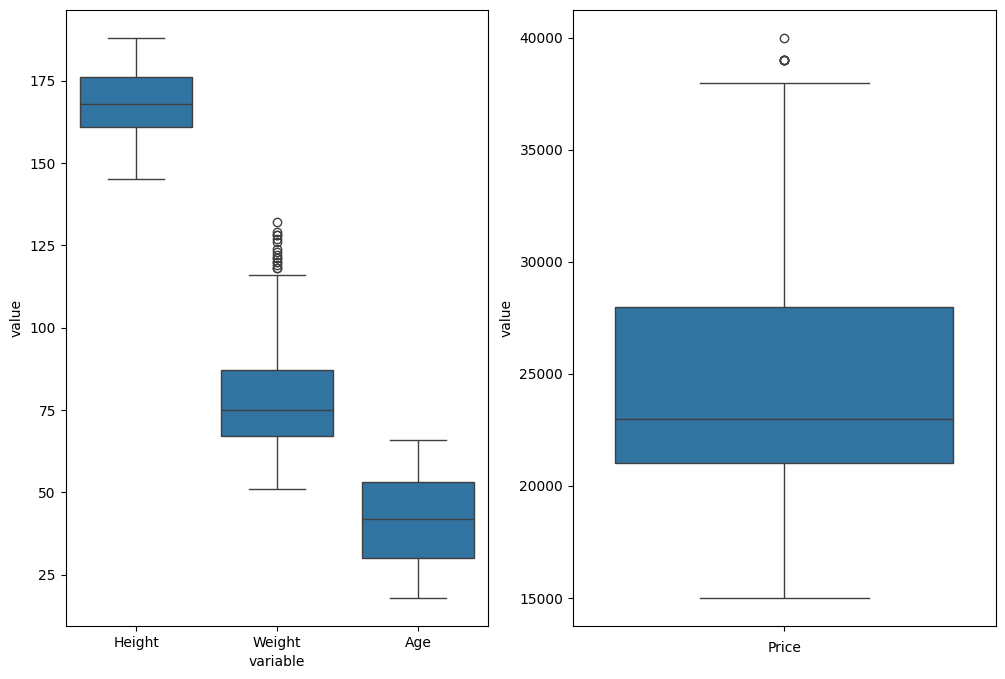

In [8]:
fig, axs = plt.subplots(1,2,figsize=(12,8))
sns.boxplot(x='variable', y='value', data=pd.melt(df[['Height', 'Weight', 'Age']]), ax=axs[0])
sns.boxplot(y='PremiumPrice',  data=df, ax=axs[1])
axs[1].set(xlabel='Price', ylabel='value')

In [9]:
weight_val = df['Weight'].describe()
weight_val

count    986.000000
mean      76.950304
std       14.265096
min       51.000000
25%       67.000000
50%       75.000000
75%       87.000000
max      132.000000
Name: Weight, dtype: float64

In what follows, the outliers are deleted and then the related features are represented again:

[Text(0.5, 0, 'Price'), Text(0, 0.5, 'value')]

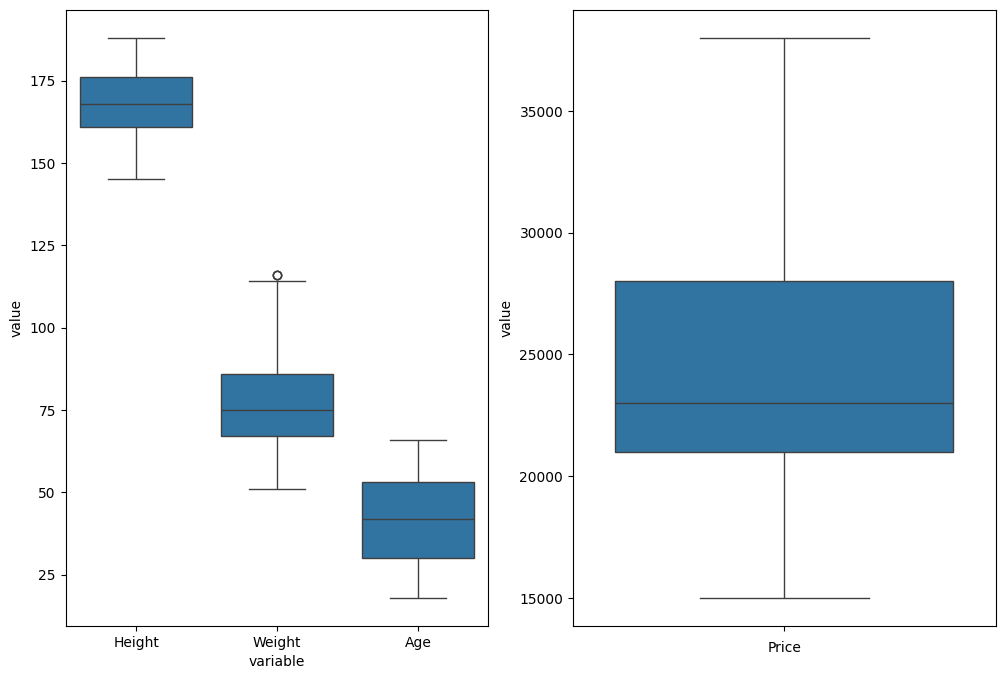

In [10]:
Q3_wei = df['Weight'].quantile(0.75)
Q1_wei = df['Weight'].quantile(0.25)
weight_lim = 1.5 * (Q3_wei - Q1_wei) + Q3_wei

Q3_pri = df['PremiumPrice'].quantile(0.75)
Q1_pri = df['PremiumPrice'].quantile(0.25)
price_lim = 1.5 * (Q3_pri - Q1_pri) + Q3_pri

df = df[(df['Weight']<weight_lim) &  (df['PremiumPrice']<price_lim)]

ig, axs = plt.subplots(1,2,figsize=(12,8))
sns.boxplot(x='variable', y='value', data=pd.melt(df[['Height', 'Weight', 'Age']]), ax=axs[0])
sns.boxplot(y='PremiumPrice',  data=df, ax=axs[1])
axs[1].set(xlabel='Price', ylabel='value')

## Select Features <a class="anchor" id="1-3-bullet"></a>

In this section, we choose the predominant features for the price prediction. First, let have a look at the correlations between the price and the other continuous features:

In [11]:
df[['Age', 'Height', 'Weight', 'PremiumPrice']].corr()

,Age,Height,Weight,PremiumPrice
Age,1.000000,0.036674,-0.007651,0.719069
Height,0.036674,1.000000,0.080146,0.037199
Weight,-0.007651,0.080146,1.000000,0.157523
PremiumPrice,0.719069,0.037199,0.157523,1.000000


As one can see, the 'Height' has very low correlation with the 'PremiumPrice'. It has also been investigated in the following figure. As you can see the variation of the price with respect to variation of the height is negligible. 

<Axes: xlabel='Height', ylabel='PremiumPrice'>

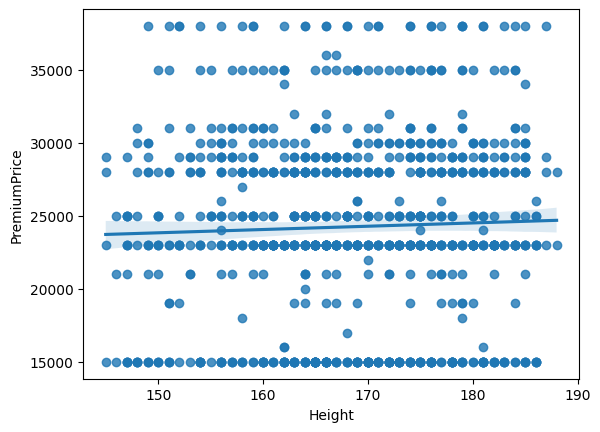

In [12]:
sns.regplot(x='Height', y='PremiumPrice', data=df)

So, we decide to delete the 'Height' from the features in the dataset:

In [13]:
df.drop(columns=['Height'], axis=1, inplace=True)

## Select Categorical Features <a class="anchor" id="1-4-bullet"></a>

similar to the continuous features, we need to explore which categorical features are the most important ones for the price prediction. This can be done by one-way analysis of variance (ANOVA) as follows:

In [14]:
df_noDiabetes = df.groupby('Diabetes').get_group(0)['PremiumPrice']
df_Diabetes = df.groupby('Diabetes').get_group(1)['PremiumPrice']
f_oneway(df_noDiabetes, df_Diabetes)

F_onewayResult(statistic=np.float64(6.1277473125365365), pvalue=np.float64(0.013478739494738259))

In [15]:
df_noBP = df.groupby('BloodPressureProblems').get_group(0)['PremiumPrice']
df_BP = df.groupby('BloodPressureProblems').get_group(1)['PremiumPrice']
f_oneway(df_noBP, df_BP)

F_onewayResult(statistic=np.float64(24.422144169163662), pvalue=np.float64(9.121787503867382e-07))

In [16]:
df_noT = df.groupby('AnyTransplants').get_group(0)['PremiumPrice']
df_T = df.groupby('AnyTransplants').get_group(1)['PremiumPrice']
f_oneway(df_noT, df_T)

F_onewayResult(statistic=np.float64(91.17626361865224), pvalue=np.float64(1.0476959317316363e-20))

In [17]:
df_noCD = df.groupby('AnyChronicDiseases').get_group(0)['PremiumPrice']
df_CD = df.groupby('AnyChronicDiseases').get_group(1)['PremiumPrice']
f_oneway(df_noCD, df_CD)

F_onewayResult(statistic=np.float64(45.18015081323932), pvalue=np.float64(3.073526340293322e-11))

In [18]:
df_noKA = df.groupby('KnownAllergies').get_group(0)['PremiumPrice']
df_KA = df.groupby('KnownAllergies').get_group(1)['PremiumPrice']
f_oneway(df_noKA, df_KA)

F_onewayResult(statistic=np.float64(0.0983333860406225), pvalue=np.float64(0.7539067857633162))

In [19]:
df_noHC = df.groupby('HistoryOfCancerInFamily').get_group(0)['PremiumPrice']
df_HC = df.groupby('HistoryOfCancerInFamily').get_group(1)['PremiumPrice']
f_oneway(df_noHC, df_HC)

F_onewayResult(statistic=np.float64(7.125705401041786), pvalue=np.float64(0.007726528974575876))

In [20]:
df_NS0 = df.groupby('NumberOfMajorSurgeries').get_group(0)['PremiumPrice']
df_NS1 = df.groupby('NumberOfMajorSurgeries').get_group(1)['PremiumPrice']
df_NS2 = df.groupby('NumberOfMajorSurgeries').get_group(2)['PremiumPrice']
df_NS3 = df.groupby('NumberOfMajorSurgeries').get_group(3)['PremiumPrice']
f_oneway(df_NS0, df_NS1, df_NS2, df_NS3)

F_onewayResult(statistic=np.float64(26.205968423877678), pvalue=np.float64(2.6861256720698395e-16))

As one can see, the p-values for the 'Diabetes', 'BloodPressureProblems', 'AnyTransplants', 'AnyChronicDiseases', and 'HistoryOfCancerInFamily' are so small (less than 0.05). Therefore, the null hypothesis that the premium price is independent of those features is rejected. Therefore, they have to be retained in the dataset. 

On the other hand, the p-value for the  'KnownAllergies' is not small. this implies that the null hypothesis that the premium price is independent of 'KnownAllergies' values is valid. So, we have to delete the 'KnownAllergies' from the dataset. 

In [21]:
df.drop(columns=['KnownAllergies'], axis=1, inplace=True)

## Convert Categorical Features <a class="anchor" id="1-5-bullet"></a>

AS we saw earlier, the values of 'NumberOfMajorSurgeries' can be 0,1,2,3. We consider it as a categorical valiable and convert it into dummy/indicator variables.

In [22]:
df['NumberOfMajorSurgeries'].value_counts()

0    470
1    363
2    116
3     16
Name: NumberOfMajorSurgeries, dtype: int64

In [22]:
df = pd.get_dummies(df, columns=['NumberOfMajorSurgeries'], drop_first=True)

In [23]:
df.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Weight,HistoryOfCancerInFamily,PremiumPrice,NumberOfMajorSurgeries_1,NumberOfMajorSurgeries_2,NumberOfMajorSurgeries_3
0,45,0,0,0,0,57,0,25000,False,False,False
1,60,1,0,0,0,73,0,29000,False,False,False
2,36,1,1,0,0,59,0,23000,True,False,False
3,52,1,1,0,1,93,0,28000,False,True,False
4,38,0,0,0,1,88,0,23000,True,False,False


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 965 entries, 0 to 985
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Age                       965 non-null    int64
 1   Diabetes                  965 non-null    int64
 2   BloodPressureProblems     965 non-null    int64
 3   AnyTransplants            965 non-null    int64
 4   AnyChronicDiseases        965 non-null    int64
 5   Weight                    965 non-null    int64
 6   HistoryOfCancerInFamily   965 non-null    int64
 7   PremiumPrice              965 non-null    int64
 8   NumberOfMajorSurgeries_1  965 non-null    bool 
 9   NumberOfMajorSurgeries_2  965 non-null    bool 
 10  NumberOfMajorSurgeries_3  965 non-null    bool 
dtypes: bool(3), int64(8)
memory usage: 70.7 KB


## Determining Normality <a class="anchor" id="1-6-bullet"></a>

For the linear regression methods it is assumed that the residuals of the model has normal distribution. Normalizing the premium price helps to have a normally distributed residuals; however, it is not necessary by assumed by the linear regression methods. In the following, we first investigate whether the premium price has normally distributed values or not.  

<Axes: >

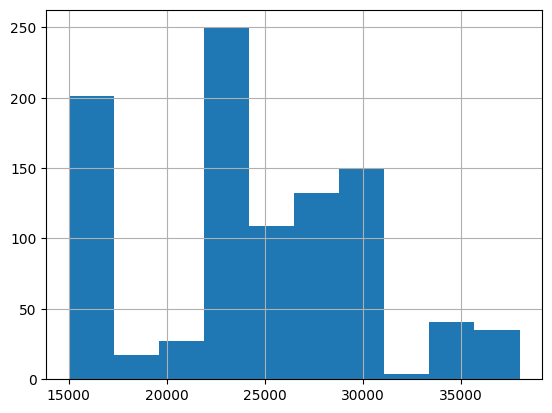

In [25]:
df.PremiumPrice.hist()

The normality can be evaluated using normaltest as follows:

In [26]:
normaltest(df.PremiumPrice)

NormaltestResult(statistic=np.float64(16.11967946721973), pvalue=np.float64(0.0003159774418077449))

Since the pvalue=0.0003 is less than 0.05 (our considered limit) the null hypothesis that the distribution is normal is rejected, so we need to apply a transformation on the Premium Price as follows :

In [27]:
PriceTrans, lmbda = boxcox(df.PremiumPrice)
print('The obtained value for lambda by boxcox transformation: %0.3f ' %lmbda)

The obtained value for lambda by boxcox transformation: 0.813 


For the linear regression usually it assumes that the residuals of the model has normal distribution. 

In [28]:
normaltest(PriceTrans)

NormaltestResult(statistic=np.float64(23.893719841226062), pvalue=np.float64(6.479547238694233e-06))

As you can see the normaltest confirms that the distribution of the premium price is now normal.

Lets have a look at the histogram of the transformed premium price now:

<Axes: >

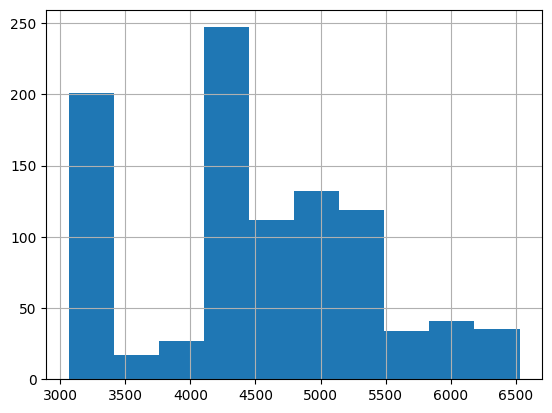

In [29]:
df['PremiumPrice'] = PriceTrans
df['PremiumPrice'].hist()

# Linear Regression <a class="anchor" id="second-bullet"></a>

The data is now clean and ready to be employed for the ML approaches. Let us first define the dependent, y, and independent, X, variables as follows:

In [30]:
X = df.drop(columns=['PremiumPrice'], axis=1)
y = df.PremiumPrice

## A simple Linear Regression<a class="anchor" id="2-1-bullet"></a>

As an initial step, we consider obtaining a plain linear regression model for our dataset to predict the premium price based on the available featuresas follows:

In [31]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, 
                                                    random_state=1979, shuffle=True)

scaler = StandardScaler()
X_tr_sc = X_tr.copy()
X_tr_sc[['Age', 'Weight']] = scaler.fit_transform(X_tr[['Age', 'Weight']])

lr = LinearRegression()
lr.fit(X_tr_sc, y_tr)

X_te_sc = X_te.copy()
X_te_sc[['Age', 'Weight']] = scaler.transform(X_te[['Age', 'Weight']])
y_te_pr = lr.predict(X_te_sc)

# since we have already transformed the premium price to have normally distributed 
# values, to evaluate the model we revert it back to the true values using inv_boxcox
# with the same value for lmbda = 0.813
y_te_true = inv_boxcox(y_te, lmbda)
y_te_pr_true = inv_boxcox(y_te_pr, lmbda)

print('The R2 Score: ', r2_score(y_true=y_te_true, y_pred=y_te_pr_true))

The R2 Score:  0.6527349019066226


Lets have a look at the obtained coefficients of our linear model:

In [32]:
lr_res = pd.DataFrame(zip(X_tr.columns.tolist(),lr.coef_)).rename({0:'Feature', 1:'Coefficient'}, axis=1)
lr_res.loc[len(lr_res.index)] = ['Intercept', lr.intercept_]
lr_res

,Feature,Coefficient
0,Age,727.534148
1,Diabetes,-13.968121
2,BloodPressureProblems,-29.841239
3,AnyTransplants,1361.886305
4,AnyChronicDiseases,382.654952
5,Weight,156.650135
6,HistoryOfCancerInFamily,292.020995
7,NumberOfMajorSurgeries_1,41.071993
8,NumberOfMajorSurgeries_2,-260.953789
9,NumberOfMajorSurgeries_3,-389.497585


Below you can see a representation of the predicted values versus the real ones:

[Text(0.5, 0, 'Ground truth'),
 Text(0, 0.5, 'Prediction'),
 Text(0.5, 1.0, 'Predicted versus True Premium Price')]

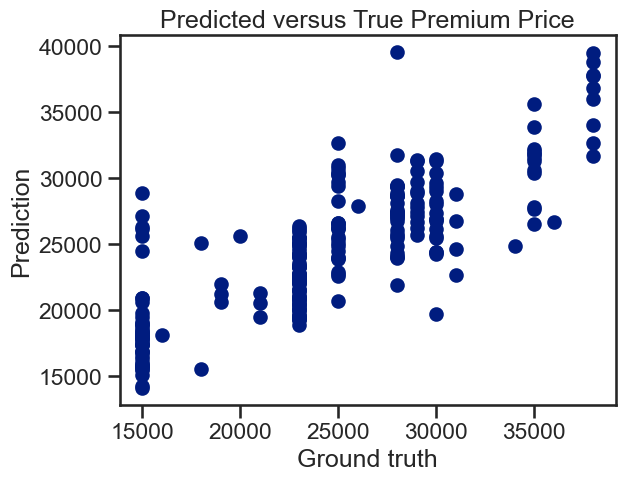

In [33]:
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('dark')

plt.scatter(x=y_te_true, y=y_te_pr_true)
ax = plt.gca()
ax.set(xlabel='Ground truth', ylabel='Prediction', title='Predicted versus True Premium Price')

# Linear Regression with Regularization <a class="anchor" id="third-bullet"></a>

Now to reduce the variance error of the model and have a better model we utilize the regularization techniques available in the scikit-learn library. As the first step, let us use the Ridge in which an l2 norm of the coefficients is also considered in the cost function to obtain the model coefficients.

### Ridge <a class="anchor" id="3-1-bullet"></a>

The best R2 score equal to 0.716 for linear regression using Ridge
is obtained with alpha = 1.072.


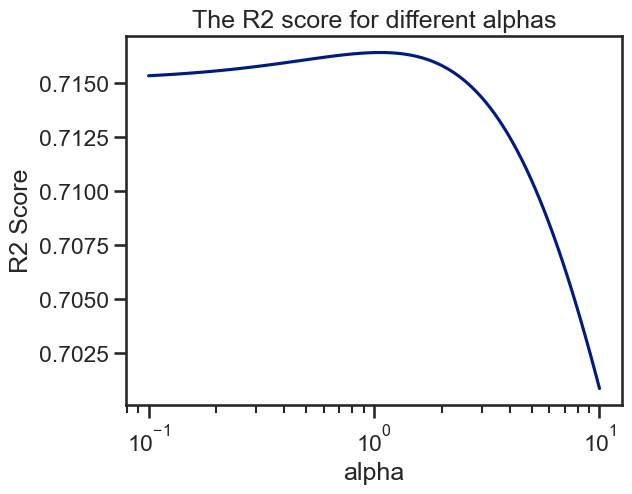

In [34]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_po = poly.fit_transform(X)

X_po_tr, X_po_te, y_tr, y_te = train_test_split(X_po, y, test_size=0.3, 
                                   shuffle=True, random_state=1979)

scaler_po = StandardScaler()
X_po_tr_sc = scaler_po.fit_transform(X_po_tr)

ridge_alphas = np.geomspace(1e-1,1e1,100)
y_te_true = inv_boxcox(y_te, lmbda)
ridge_res = list()

for alpha in ridge_alphas:
    ridge = Ridge(alpha=alpha, max_iter=100000)
    ridge.fit(X_po_tr_sc, y_tr)

    X_po_te_sc = scaler_po.transform(X_po_te)
    y_te_pr = ridge.predict(X_po_te_sc)

    y_te_pr_true = inv_boxcox(y_te_pr, lmbda)
    ridge_res.append(r2_score(y_true=y_te_true, y_pred=y_te_pr_true))

ax =plt.axes()
ax.semilogx(ridge_alphas, ridge_res)
ax.set(xlabel='alpha', ylabel='R2 Score', title='The R2 score for different alphas')


print('''The best R2 score equal to {0:1.3f} for linear regression using Ridge
is obtained with alpha = {1:1.3f}.'''.format(np.max(ridge_res), ridge_alphas[np.argmax(ridge_res)]))


Now, lets have a look at the root mean squared error (rmse) and the R2 score for the obtained model. Furthermore, we investigate the number of features whose related coefficients are zero.

In [36]:
ridge_alpha_best = ridge_alphas[np.argmax(ridge_res)]

ridge = Ridge(alpha=ridge_alpha_best, max_iter=100000)
ridge.fit(X_po_tr_sc, y_tr)

y_te_pr = ridge.predict(X_po_te_sc)
y_te_pr_true = inv_boxcox(y_te_pr, lmbda)
ridge_rmse = mean_squared_error(y_true=y_te_true, y_pred=y_te_pr_true, squared=False )


print('The sum of coefficients obtained by Ridge: %4.4f' %abs(ridge.coef_).sum())

print('The number of zero coefficients equal to %i.' %len(ridge.coef_[ridge.coef_==0]))

print('''The root mean squared error (rmse) equal to {0:1.3f} for linear regression using Ridge
is obtained with alpha = {1:1.3f}.'''.format(ridge_rmse, ridge_alphas[np.argmax(ridge_res)]))

The sum of coefficients obtained by Ridge: 8817.9801
The number of zero coefficients equal to 6.
The root mean squared error (rmse) equal to 3271.728 for linear regression using Ridge
is obtained with alpha = 1.072.


## LASSO <a class="anchor" id="3-2-bullet"></a>

Alternatively, we use LASSO in which an l1 norm of the coefficients contributed into the cost function to obtain the coefficients of the linear model. 

The best R2 score equal to 0.720 for linear regression using Lasso
    is obtained with alpha = 1.707.


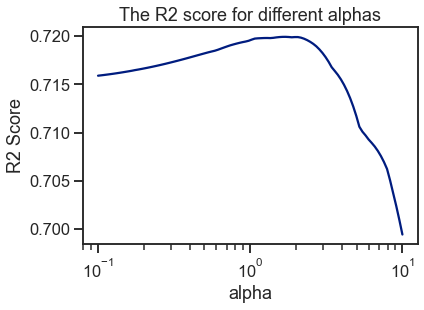

In [37]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_po = poly.fit_transform(X)

X_po_tr, X_po_te, y_tr, y_te = train_test_split(X_po, y, test_size=0.3, 
                                   shuffle=True, random_state=1979)

scaler_po = StandardScaler()
X_po_tr_sc = scaler_po.fit_transform(X_po_tr)

lasso_alphas = np.geomspace(1e-1,1e1,100)
y_te_true = inv_boxcox(y_te, lmbda)
lasso_res = list()

for alpha in lasso_alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_po_tr_sc, y_tr)

    X_po_te_sc = scaler_po.transform(X_po_te)
    y_te_pr = lasso.predict(X_po_te_sc)

    y_te_pr_true = inv_boxcox(y_te_pr, lmbda)
    lasso_res.append(r2_score(y_true=y_te_true, y_pred=y_te_pr_true))

ax = plt.axes()
ax.semilogx(lasso_alphas, lasso_res)
ax.set(xlabel='alpha', ylabel='R2 Score', title='The R2 score for different alphas')

print('''The best R2 score equal to {0:1.3f} for linear regression using Lasso
    is obtained with alpha = {1:1.3f}.'''.format(np.max(lasso_res), lasso_alphas[np.argmax(lasso_res)]))

In [38]:
lasso_alpha_best = lasso_alphas[np.argmax(lasso_res)]

lasso = Lasso(alpha=lasso_alpha_best, max_iter=100000)
lasso.fit(X_po_tr_sc, y_tr)

y_te_pr = lasso.predict(X_po_te_sc)
y_te_pr_true = inv_boxcox(y_te_pr, lmbda)
lasso_rmse = mean_squared_error(y_true=y_te_true, y_pred=y_te_pr_true, squared=False )

print('The sum of coefficients obtained by Lasso: %4.4f' %abs(lasso.coef_).sum())

print('The number of zero coefficients equal to %i.' %len(lasso.coef_[lasso.coef_==0]))

print('''The root mean squared error (rmse) equal to {0:1.3f} for linear regression using Lasso
is obtained with alpha = {1:1.3f}.'''.format(lasso_rmse, lasso_alphas[np.argmax(lasso_res)]))

The sum of coefficients obtained by Lasso: 6542.3454
The number of zero coefficients equal to 21.
The root mean squared error (rmse) equal to 3251.581 for linear regression using Lasso
is obtained with alpha = 1.707.


As one can easily see, the number of features with zero coefficients is higher that of Ridge in the obtained model by LASSO. 

##  Elastic Net <a class="anchor" id="3-3-bullet"></a>

Elastic Net takes advantage of both l1 and l2 norms of the coefficients for the regularization. The obtained results by ElasticNet() is given below:

The best R2 score equal to 0.716 for linear regression using Elastic Net
    is obtained with alpha = 0.003.


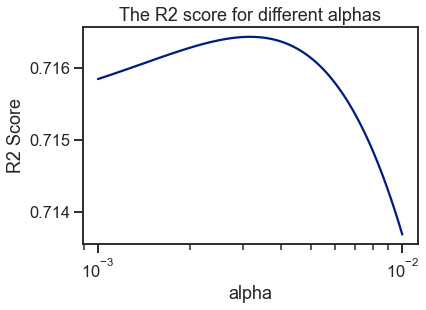

In [39]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_po = poly.fit_transform(X)

X_po_tr, X_po_te, y_tr, y_te = train_test_split(X_po, y, test_size=0.3, 
                                   shuffle=True, random_state=1979)

scaler_po = StandardScaler()
X_po_tr_sc = scaler_po.fit_transform(X_po_tr)

elastic_alphas = np.geomspace(1e-3,1e-2,100)
y_te_true = inv_boxcox(y_te, lmbda)
elastic_res = list()

for alpha in elastic_alphas:
    elastic = ElasticNet(alpha=alpha, l1_ratio=0.5, max_iter=10000)
    elastic.fit(X_po_tr_sc, y_tr)

    X_po_te_sc = scaler_po.transform(X_po_te)
    y_te_pr = elastic.predict(X_po_te_sc)

    y_te_pr_true = inv_boxcox(y_te_pr, lmbda)
    elastic_res.append(r2_score(y_true=y_te_true, y_pred=y_te_pr_true))

ax = plt.axes()
ax.semilogx(elastic_alphas, elastic_res)
ax.set(xlabel='alpha', ylabel='R2 Score', title='The R2 score for different alphas')

print('''The best R2 score equal to {0:1.3f} for linear regression using Elastic Net
    is obtained with alpha = {1:1.3f}.'''.format(np.max(elastic_res), elastic_alphas[np.argmax(elastic_res)]))

In [40]:
elastic_alpha_best = elastic_alphas[np.argmax(elastic_res)]
elastic = ElasticNet(alpha=elastic_alpha_best, max_iter=100000)
elastic.fit(X_po_tr_sc, y_tr)

y_te_pr = elastic.predict(X_po_te_sc)
y_te_pr_true = inv_boxcox(y_te_pr, lmbda)
elastic_rmse = mean_squared_error(y_true=y_te_true, y_pred=y_te_pr_true, squared=False )


print('The sum of coefficients obtained by Elastic Net: %4.4f' %abs(elastic.coef_).sum())

print('The number of zero coefficients equal to %i.' %len(elastic.coef_[elastic.coef_==0]))

print('''The root mean squared error (rmse) equal to {0:1.3f} for linear regression using Elastic Net
is obtained with alpha = {1:1.3f}.'''.format(elastic_rmse, elastic_alphas[np.argmax(elastic_res)]))

The sum of coefficients obtained by Elastic Net: 8827.4063
The number of zero coefficients equal to 6.
The root mean squared error (rmse) equal to 3271.687 for linear regression using Elastic Net
is obtained with alpha = 0.003.


## Linear Regression Results <a class="anchor" id="3-4-bullet"></a>

For the comparison purposes, we have summarized the obtained results by Ridge, Lasso, and ElasticNet in this subsection.

In [41]:
ridge_series = pd.Series([abs(ridge.coef_).sum().round(2), len(ridge.coef_[ridge.coef_==0]),
                         np.max(ridge_res).round(4), np.max(ridge_rmse).round(2)],
                        index=['Sum of coeff.', 'Number of zero Coeff.', 'R2 score', 'RMSE'],
                        name='Ridge')

lasso_series = pd.Series([abs(lasso.coef_).sum().round(2), len(lasso.coef_[lasso.coef_==0]),
                         np.max(lasso_res).round(4), np.max(lasso_rmse).round(2)],
                        index=['Sum of coeff.', 'Number of zero Coeff.', 'R2 score', 'RMSE'],
                        name='Lasso')

elastic_series = pd.Series([abs(elastic.coef_).sum().round(2), len(elastic.coef_[elastic.coef_==0]),
                         np.max(elastic_res).round(4), np.max(elastic_rmse).round(2)],
                        index=['Sum of coeff.', 'Number of zero Coeff.', 'R2 score', 'RMSE'],
                        name='Elastic Net')

RES = pd.DataFrame([ridge_series, lasso_series, elastic_series])

In [42]:
RES

,Sum of coeff.,Number of zero Coeff.,R2 score,RMSE
Ridge,8817.98,6.0,0.7164,3271.73
Lasso,6542.35,21.0,0.7199,3251.58
Elastic Net,8827.41,6.0,0.7164,3271.69


## Linear Regression: Cross-Validation <a class="anchor" id="3-5-bullet"></a>

To improve the performance of our linear model, we have considered adding some new features to our dataset as follows. 

In [43]:
X['new1'] = X['Weight'] / X['Age'] 
X['new2'] = X['Diabetes'] * X['BloodPressureProblems'] * X['AnyTransplants'] * X['AnyChronicDiseases']

Now, using the aforementioned introduced features and taking advantage of LassoCV, RidgeCV, and ElasticNetCV, we have evaluated the impacts of adding these new features to our dataset as follows: 

In [44]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, 
                                    random_state=1979, shuffle=True)


poly = PolynomialFeatures(degree=2, include_bias=False)
X_tr_po = poly.fit_transform(X_tr)

scaler_po = StandardScaler()
X_tr_po_sc = scaler_po.fit_transform(X_tr_po)
y_te_true = inv_boxcox(y_te, lmbda)

X_te_po = poly.transform(X_te)
X_te_po_sc = scaler_po.transform(X_te_po)

alphas = np.geomspace(1e-3,1e3,1000)

kf = KFold(n_splits=5, shuffle=True, random_state=1980)

lasCV = LassoCV(alphas=alphas, cv=kf)
ridCV = RidgeCV(alphas=alphas, cv=kf)
elaCV = ElasticNetCV(alphas=alphas, l1_ratio=0.5, cv=kf)

estimators = [lasCV, ridCV, elaCV]

R2 = list()
RMSE = list()

for estimator in estimators:
    estimator.fit(X_tr_po_sc, y_tr)
    y_te_pr = estimator.predict(X_te_po_sc)
    y_te_pr_true = inv_boxcox(y_te_pr, lmbda) 
    
    r2 = r2_score(y_true=y_te_true , y_pred=y_te_pr_true)
    rmse = mean_squared_error(y_true=y_te_true, y_pred=y_te_pr_true, squared=False)
    
    R2.append(r2), RMSE.append(rmse)
    
pd.DataFrame({'R2 score': R2, 'RMSE': RMSE}, index=['Ridge', 'Lasso', 'Elastic Net'] )

,R2 score,RMSE
Ridge,0.759160,3029.111040
Lasso,0.758380,3034.009969
Elastic Net,0.758525,3033.095767


It would be interesting to compare the coefficients obtained by different methods. In the figure below, you can see the obtained coefficients by the applied methods:

Text(0, 0.5, 'Value')

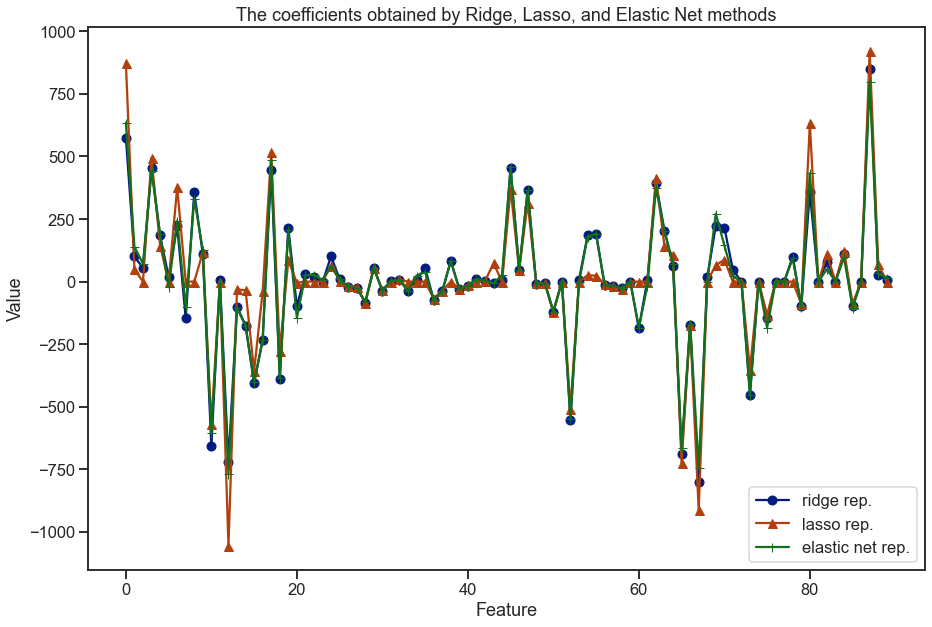

In [45]:
colors = sns.color_palette()

fig = plt.figure(figsize=(15,10))
plt.plot(ridCV.coef_, color=colors[0], marker='o', label='ridge rep.')
plt.plot(lasCV.coef_, color=colors[1], marker='^', label='lasso rep.')
plt.plot(elaCV.coef_, color=colors[2], marker='+', label='elastic net rep.')
plt.legend()
plt.title('The coefficients obtained by Ridge, Lasso, and Elastic Net methods')
plt.xlabel('Feature')
plt.ylabel('Value')

## Linear Regression: Different Scalers <a class="anchor" id="3-6-bullet"></a>

In this section, we consider evaluating the impact of the scalers on the ultimate results. Using cross_val_predict, we choose the best scaler between MAxAbsScaler(), MinMAxScaler(), and StandardScaler() resulting in the best R2 score for the models obtained by Lasso. 

In [46]:
scaler_list = [MaxAbsScaler(), MinMaxScaler(), StandardScaler()]
alphas = np.geomspace(1e-2,1e2, 100)

poly = PolynomialFeatures(degree=2)
kf = KFold(n_splits=5, shuffle=True, random_state=1979)

scores = list()
alpha_val = list()
scaler_val = list()
for sca in scaler_list:
    for alpha in alphas:
        las = Lasso(alpha=alpha)

        estimator = Pipeline([('Polynomial_features', poly), ('scaler', sca), ('lasso_reg', las)])
        scaler_val.append(sca)
        predictions = cross_val_predict(estimator, X, y, cv=kf)
        scores.append(r2_score(y_true=y, y_pred=predictions))
        alpha_val.append(alpha)
              
RES = pd.DataFrame({'alpha':alpha_val, 'Scaler':scaler_val, 'R2 score':scores})

print('The best scaler: \n', RES[ RES['R2 score']== RES['R2 score'].max()] )


The best scaler: 
         alpha          Scaler  R2 score
126  0.112332  MinMaxScaler()  0.754776


The best scaler is MinMaxScaler() when Lasso is used to obtain a linear model. 

## Linear Rgression: Hyperparameter Tuning <a class="anchor" id="3-7-bullet"></a>

In this section, we tackle the hyperparameter tuning problem. In what follows, using Pipeline and GridSearchCV, we consider the problem of choosing the best values for parameter alpha and the degree of the polynomial features to obtain the best possible linear model. 

In [47]:
kf = KFold(n_splits=5, shuffle=True, random_state=1979)

poly = PolynomialFeatures()
sca = StandardScaler()
las = Ridge()

alphas= np.geomspace(1e-2, 1e2, num=100)

estimator = Pipeline([('Polynomial_features', poly),
                      ('Scaler', sca),
                      ('Regression', las)])

params = {'Polynomial_features__degree': [1, 2, 3],
          'Regression__alpha': alphas }

grid = GridSearchCV(estimator, params, cv=kf)

In [48]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, 
                                    random_state=1979, shuffle=True)

grid.fit(X_tr, y_tr)

GridSearchCV(cv=KFold(n_splits=5, random_state=1979, shuffle=True),
             estimator=Pipeline(steps=[('Polynomial_features',
                                        PolynomialFeatures()),
                                       ('Scaler', StandardScaler()),
                                       ('Regression', Ridge())]),
             param_grid={'Polynomial_features__degree': [1, 2, 3],
                         'Regression__alpha': array([1.00000000e-02, 1.09749877e-02, 1.20450354e-02, 1.32194115e-02,
       1.45082878e-02, 1.5922827...
       1.17681195e+01, 1.29154967e+01, 1.41747416e+01, 1.55567614e+01,
       1.70735265e+01, 1.87381742e+01, 2.05651231e+01, 2.25701972e+01,
       2.47707636e+01, 2.71858824e+01, 2.98364724e+01, 3.27454916e+01,
       3.59381366e+01, 3.94420606e+01, 4.32876128e+01, 4.75081016e+01,
       5.21400829e+01, 5.72236766e+01, 6.28029144e+01, 6.89261210e+01,
       7.56463328e+01, 8.30217568e+01, 9.11162756e+01, 1.00000000e+02])})

In the aforementioned design, we confined ourselves to use SatndardScaler() and Ridge() to design the model. In the scenario, the best obtained values for the polynomial degree and alpha are as follows: 

In [49]:
grid.best_score_, grid.best_params_

(0.7358033679193989,
 {'Polynomial_features__degree': 2, 'Regression__alpha': 1.6681005372000592})

Now, lets have a look at the obtained value for the R2 score:

In [50]:
y_te_pre = grid.predict(X_te)

y_te_true = inv_boxcox(y_te, lmbda)
y_te_pre_true = inv_boxcox(y_te_pre, lmbda)
r2_score(y_true=y_te_true , y_pred=y_te_pre_true)

0.7546404201933999

Now, we are at the point that to consider a more general hyperparameter tuning problem in which the method, scaler, polynomial degree, alpha (and l1_ratio) to be considered in the tuning problem. In what follows, we choose the best possible linear model for our dataset by tuning all the hyperparameters systematically. 

In [51]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, 
                                    random_state=1979, shuffle=True)

kf = KFold(n_splits=5, shuffle=True, random_state=1979)

BEST_SCORES = list()
BEST_DEGREE = list()
BEST_ALPHA = list()
SCALER = list()
METHODS = list()
R2_TEST = list()
L1_RATIO = list()

poly = PolynomialFeatures()
scalers = [StandardScaler(), MinMaxScaler(), MaxAbsScaler()]
methods = [Ridge(), Lasso(), ElasticNet()]

alphas= np.geomspace(1e-2, 1e2, num=10)
l1_ratios = np.linspace(0,1,num=10)

for scaler in scalers:
    for method in methods:

        estimator = Pipeline([('Polynomial_features', poly),
                              ('Scaler', scaler),
                              ('Regression', method)])
        
        if str(method)=='ElasticNet()':
            params = {'Polynomial_features__degree': [1, 2, 3],
                      'Regression__alpha': alphas,
                      'Regression__l1_ratio': l1_ratios
                      }
        else:
            params = {'Polynomial_features__degree': [1, 2, 3],
                      'Regression__alpha': alphas
                      }
        

        grid = GridSearchCV(estimator, params, cv=kf)
        grid.fit(X_tr, y_tr)
        y_te_pre = grid.predict(X_te)
        y_te_true = inv_boxcox(y_te, lmbda)
        y_te_pre_true = inv_boxcox(y_te_pre, lmbda)
        r2_te = r2_score(y_true=y_te_true , y_pred=y_te_pre_true)
        
        BEST_SCORES.append(grid.best_score_)
        BEST_DEGREE.append(grid.best_params_['Polynomial_features__degree'])
        BEST_ALPHA.append(grid.best_params_['Regression__alpha'])
        SCALER.append(scaler)
        METHODS.append(method)
        R2_TEST.append(r2_te)
        
        if str(method)=='ElasticNet()':
            L1_RATIO.append(grid.best_params_['Regression__l1_ratio'])
        else:
            L1_RATIO.append(np.nan)
        
        
RES = pd.DataFrame({'R2 Score':BEST_SCORES, 'Alpha': BEST_ALPHA, 'L1_ratio':L1_RATIO,
                    'Polynomial Degree':BEST_DEGREE,
                     'Scaler':SCALER, 'Methods': METHODS , 'R2 Score:Test Set':R2_TEST} )
RES

,R2 Score,Alpha,L1_ratio,Polynomial Degree,Scaler,Methods,R2 Score:Test Set
0,0.767626,0.599484,NaN,2,StandardScaler(),Ridge(),0.740633
1,0.766831,0.599484,NaN,2,StandardScaler(),Lasso(),0.739757
2,0.766831,0.599484,1.0,2,StandardScaler(),ElasticNet(),0.739757
3,0.767205,0.010000,NaN,2,MinMaxScaler(),Ridge(),0.740074
4,0.767100,0.077426,NaN,2,MinMaxScaler(),Lasso(),0.738691
5,0.767100,0.077426,1.0,2,MinMaxScaler(),ElasticNet(),0.738691
6,0.767163,0.010000,NaN,2,MaxAbsScaler(),Ridge(),0.739869
7,0.767203,0.077426,NaN,2,MaxAbsScaler(),Lasso(),0.738746
8,0.767203,0.077426,1.0,2,MaxAbsScaler(),ElasticNet(),0.738746


# Final Model <a class="anchor" id="fourth-bullet"></a>

As one can see in the previous cell, the best model can be chosen based on the R2 score computed for the test set. This would be the best model that we could use to obtain a linear model for our dataset. 

In [52]:
opt_degree = RES[RES['R2 Score:Test Set']==RES['R2 Score:Test Set'].max()]['Polynomial Degree'].values[0]
opt_scaler = RES[RES['R2 Score:Test Set']==RES['R2 Score:Test Set'].max()]['Scaler'].values[0]
opt_alpha = RES[RES['R2 Score:Test Set']==RES['R2 Score:Test Set'].max()]['Alpha'].values[0]
opt_method = RES[RES['R2 Score:Test Set']==RES['R2 Score:Test Set'].max()]['Methods'].values[0]
opt_L1_ratio = RES[RES['R2 Score:Test Set']==RES['R2 Score:Test Set'].max()]['L1_ratio'].values[0]

poly = PolynomialFeatures()

pipe = Pipeline([('Polynomial_features', poly), ('scaler', opt_scaler), ('Regression', opt_method)])

if str(opt_method)=='ElasticNet':
    pipe.set_params(Polynomial_features__degree=opt_degree, Regression__alpha=opt_alpha,
                   Regression__l1_ratio=opt_L1_ratio)
else:
    pipe.set_params(Polynomial_features__degree=opt_degree, Regression__alpha=opt_alpha)

pipe.fit(X_tr,y_tr)
print('The obtained value for alpha for the train set: ', pipe.score(X_tr,y_tr))

The obtained value for alpha for the train set:  0.8241369242509781


In [53]:
y_te_pre = pipe.predict(X_te)
y_te_true = inv_boxcox(y_te, lmbda)
y_te_pre_true = inv_boxcox(y_te_pre, lmbda)

r2_te = r2_score(y_true=y_te_true , y_pred=y_te_pre_true)
print('The alpha value for the test set: ', r2_te)

rmse = mean_squared_error(y_true=y_te_true, y_pred=y_te_pre_true, squared=False)
print('The rmse value for the test set: ', rmse)

The alpha value for the test set:  0.7406332390452082
The rmse value for the test set:  3113.5710135314102


Finally, you can see the predicted values for the considered test set as follows:

[Text(0.5, 0, 'Ground Truth'),
 Text(0, 0.5, 'Prediction'),
 Text(0.5, 1.0, 'Prection versus true values for premium price')]

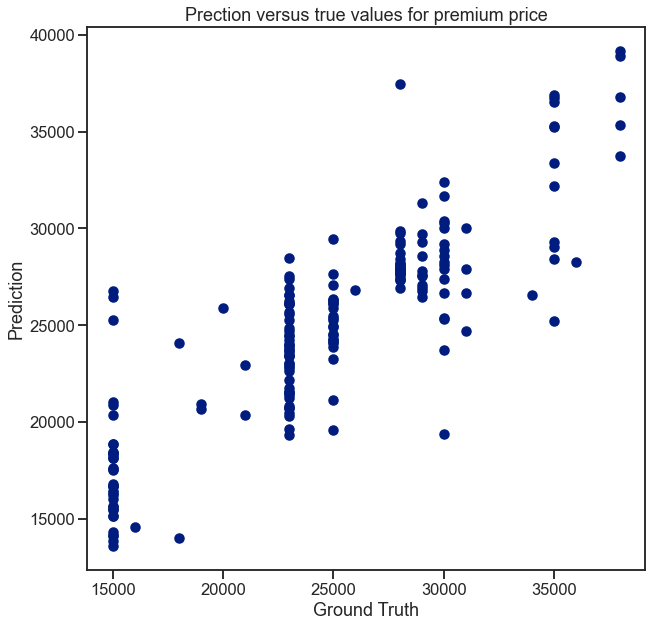

In [54]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x=y_te_true, y=y_te_pre_true)
ax.set(xlabel='Ground Truth', ylabel='Prediction', title='Prection versus true values for premium price')

To recapitulate, for the considered dataset, we added to new features, and exploiting a systematically hyperparameter tuning a linear model is obtained. We explored different available methods in scikit-learn to design our linear regression model. 